In [1]:
import numpy as np
import torch
import scipy.linalg as sla
import matplotlib.pyplot as plt
from models import *
from pl_modules.LAModel import LAModel
from utils.traditions import *
from utils.deltas import normal
from scipy import sparse
from pathlib import Path
from matplotlib import cm

In [41]:
def save_img(path, f, pre, ans, xx, yy, high_precision=False):

    # Plot force function f
    fig, ax = plt.subplots()
    fig.set_figheight(10)
    fig.set_figwidth(10)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    im = ax.imshow(f)
    plt.colorbar(im, shrink=0.8, ax=ax)
    fig.savefig(f"{path/'f.png'}", bbox_inches='tight')
    plt.close(fig)

    # plot surface of prediction
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    fig.set_figheight(10)
    fig.set_figwidth(10)
    # ax.set_aspect('equal', adjustable='box')

    surf_pre = ax.plot_surface(xx, yy, pre, cmap=cm.coolwarm,)
    plt.colorbar(surf_pre, shrink=0.8, ax=ax)
    fig.savefig(f"{path/'pre.png'}", bbox_inches='tight')
    plt.close(fig)

    # plot surface of answer
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    fig.set_figheight(10)
    fig.set_figwidth(10)
    # ax.set_aspect('equal', adjustable='box')

    surf_pre = ax.plot_surface(xx, yy, ans, cmap=cm.coolwarm,)
    plt.colorbar(surf_pre, shrink=0.8, ax=ax)
    fig.savefig(f"{path/'ans.png'}", bbox_inches='tight')
    plt.close(fig)

    # plot contourf of difference between real answer and prediction
    fig, ax = plt.subplots()
    fig.set_figheight(10)
    fig.set_figwidth(10)
    ax.set_aspect('equal', adjustable='box')

    ct = ax.contourf(np.abs(ans - pre))
    plt.colorbar(ct, shrink=0.8, ax=ax)
    fig.savefig(f"{path/'diff.png'}", bbox_inches='tight')
    plt.close(fig)

    # plot contour of prediction and real answer
    fig, ax = plt.subplots()
    fig.set_figheight(10)
    fig.set_figwidth(10)
    # ax.set_aspect('equal', adjustable='box')

    if high_precision:
        levels = [k * 0.01 for k in range(2, 10, 2)]
    else:
        levels = [-(k) * 0.06 for k in range(3, 13, 3)][::-1] + [ -0.12, -0.06]
    ct1 = ax.contour(xx, yy, pre, colors='b', linestyles = 'dashed', linewidths=5, levels=levels)
    ct2 = ax.contour(xx, yy, ans, colors='r', linestyles = 'solid', linewidths=3, levels=levels)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    # ax.clabel(ct1, inline=False, fontsize=20)
    # ax.clabel(ct2, inline=False, fontsize=20)
    h1, _ = ct1.legend_elements()
    h2, _ = ct2.legend_elements()
    ax.legend([h1[0], h2[0]], ['Prediction', 'Reference'], prop={'size': 18})
    fig.savefig(f"{path/'contour.png'}", bbox_inches='tight')
    plt.close(fig)

def draw_img(name, pre, ans, xx, yy, high_precision=False):
    fig = plt.figure()
    fig.suptitle(name, fontsize=20)
    fig.set_figheight(20)
    fig.set_figwidth(20)

    ax1 = fig.add_subplot(2, 2, 1, projection='3d')
    ax2 = fig.add_subplot(2, 2, 2, projection='3d')
    ax3 = fig.add_subplot(2, 2, 3, aspect="equal")
    ax4 = fig.add_subplot(2, 2, 4, aspect="equal")

    ax1.set_title(f'$Pre U$', fontsize=20)
    surf_pre = ax1.plot_surface(xx, yy, pre, cmap=cm.coolwarm,)
    plt.colorbar(surf_pre, shrink=0.8, ax=ax1)

    ax2.set_title(f'$Ans U$', fontsize=20)
    surf_ans = ax2.plot_surface(xx, yy, ans, cmap=cm.coolwarm,)
    plt.colorbar(surf_ans, shrink=0.8, ax=ax2)

    ax3.set_title(f'Difference', fontsize=20)
    ct = ax3.contourf(xx, yy, np.abs(ans - pre))
    plt.colorbar(ct, shrink=0.8, ax=ax3)

    if high_precision:
        levels = [k * 0.01 for k in range(1, 10, 2)]
    else:
        levels = [-(k) * 0.06 for k in range(1, 10, 2)][::-1]

    ct1 = ax4.contour(xx, yy, pre, colors='b', linestyles = 'dashed', linewidths=1.5, levels=levels)
    ct2 = ax4.contour(xx, yy, ans, colors='r', linestyles = 'solid',linewidths=2.5, levels=levels)
    # ax4.clabel(ct1, inline=True, fontsize=20)
    # ax4.clabel(ct2, inline=True, fontsize=20)
    h1, _ = ct1.legend_elements()
    h2, _ = ct2.legend_elements()
    ax4.legend([h1[0], h2[0]], ['Predicted', 'Numerical'], prop={'size': 18})

    fig.tight_layout()
    plt.show()
    plt.close(fig)

def draw_block(name, f, pre, ans, xx, yy):
    fig = plt.figure()
    fig.suptitle(name, fontsize=20)
    fig.set_figheight(20)
    fig.set_figwidth(30)

    ax1 = fig.add_subplot(2, 3, 1, aspect="equal")
    ax2 = fig.add_subplot(2, 3, 2, projection='3d')
    ax3 = fig.add_subplot(2, 3, 3, projection='3d')
    ax4 = fig.add_subplot(2, 3, 4, aspect="equal")
    ax5 = fig.add_subplot(2, 3, 5, aspect="equal")
    ax6 = fig.add_subplot(2, 3, 6, aspect="equal")

    im = ax1.imshow(f)
    plt.colorbar(im, shrink=0.8, ax=ax1)

    ax2.set_title(f'$Prediction$', fontsize=20)
    surf_pre = ax2.plot_surface(xx, yy, pre, cmap=cm.Spectral_r,)
    plt.colorbar(surf_pre, shrink=0.8, ax=ax2)

    ax3.set_title(f'$Reference$', fontsize=20)
    surf_ans = ax3.plot_surface(xx, yy, ans, cmap=cm.Spectral_r,)
    plt.colorbar(surf_ans, shrink=0.8, ax=ax3)

    ax4.set_title(f'Difference', fontsize=20)
    ct = ax4.contourf(xx, yy, (ans - pre), cmap=cm.Spectral_r, levels=50)
    plt.colorbar(ct, shrink=0.8, ax=ax4)

    levels = np.linspace(0, ans.max(), 20)
    # pm1 = ax5.pcolormesh(xx, yy, pre, cmap=cm.coolwarm)
    # ct1 = ax5.contour(xx, yy, pre, colors='white', 
    #                   linestyles = 'solid', linewidths=1, levels=levels)
    ct1 = ax5.contourf(xx, yy, pre, alpha=1, cmap=cm.Spectral_r, levels=50)
    plt.colorbar(ct1, shrink=0.8, ax=ax5)


    # pm2 = ax6.pcolormesh(xx, yy, ans, cmap=cm.coolwarm)
    # ct2 = ax6.contour(xx, yy, ans, colors='white', 
    #                   linestyles = 'solid', linewidths=1, levels=levels)
    ct2 = ax6.contourf(xx, yy, pre, alpha=1, cmap=cm.Spectral_r, levels=50)
    plt.colorbar(ct2, shrink=0.8, ax=ax6)

    fig.tight_layout()
    plt.show()
    plt.close(fig)


In [ ]:
def test_point_cases(cases, ckpt_path, imgs_save_path, a=1):
    for folder in ckpt_path.glob('*mixed*'):

        # Get all parameters from the ckpt name
        backward_method, n, model_name, features, bs, data_type = folder.name.split('_')
        n = int(n)
        layers = int(model_name[-1])
        model_name = model_name[:-1]
        features = int(features)
        bs = int(bs[2:])
        boundary_type = data_type[-1]
        data_type = data_type[:-1]

        h = 2*a / (n -1)
        h2 = h ** 2
        x = np.linspace(-a, a, n)
        y = np.linspace(-a, a, n)
        xx, yy = np.meshgrid(x, y)
        
        # get network
        mat_path = f'./data/{n}/mat/'
        net = model_names[model_name](layers = layers, features = features, boundary_type = boundary_type)
        pl_module = LAModel(net, a, n, data_path = mat_path, backward_type=backward_method, boundary_type=boundary_type)

        # get matrix
        lu, piv = sla.lu_factor(pl_module.A.to_dense().numpy())
        
        #get image save path and ckpy file path
        img_path = imgs_save_path/folder.name
        ckpt = folder/'version_0'/'checkpoints'/'last.ckpt'

        # Load ckpt
        ckpt = torch.load(ckpt)
        pl_module.load_state_dict(ckpt['state_dict'])
        pl_module.freeze()

        # Test all cases
        for i, case in enumerate(cases):
            case_img_save_path = img_path/f'case{i}'
            if not case_img_save_path.is_dir():
                case_img_save_path.mkdir(parents=True, exist_ok = True)
            
            # Get input tensor for networks
            f = np.zeros((n, n))
            for info in case:
                px, py, q = info
                f -= q * normal(xx, yy, h, (px, py))
            input_tensor = np.stack([xx, yy, f], axis=0)
            input_tensor = torch.from_numpy(input_tensor).float()
        
            # Get b for linear equations, If the value of boundary changed should fix here
            b = f.reshape(n**2) * h2
            if boundary_type == 'D':
                b = apply_diri_bc(b, {'top':0, 'bottom':0, 'left':0, 'right':0})
            elif boundary_type == 'N':
                b = apply_diri_bc(b)
                b = apply_neumann_bc(b, h, f)

            # get predicted value and real ans
            ans = sla.lu_solve((lu, piv), b).reshape(n, n)
            pre = pl_module(input_tensor[None, ...])
            pre = pl_module.padder(pre).numpy().reshape(n, n)

            # Draw
            # draw_img(f'{folder.name}_case{i}', pre, ans, xx, yy, False)

            # Save images
            save_img(case_img_save_path, f, pre, ans, xx, yy, False)

cases = [
    [(0, 0, 1)],
    [(-0.5, -0.5, 1), (0.5, 0.5, 1)],
    [(0, 0.5, 1), (-0.5, -0.5, 1), (0.5, -0.5, 1)],
    [(-0.5, -0.5, 1), (0.5, 0.5, 1), (-0.5, 0.5, 1), (0.5, -0.5, 1)],
    [(0, 0, 1), (-0.5, -0.5, 1), (0.5, 0.5, 1), (-0.5, 0.5, 1), (0.5, -0.5, 1)],
]
ckpt_path = Path('./lightning_logs/')
imgs_save_path = Path('./images/')
test_point_cases(cases, ckpt_path, imgs_save_path)

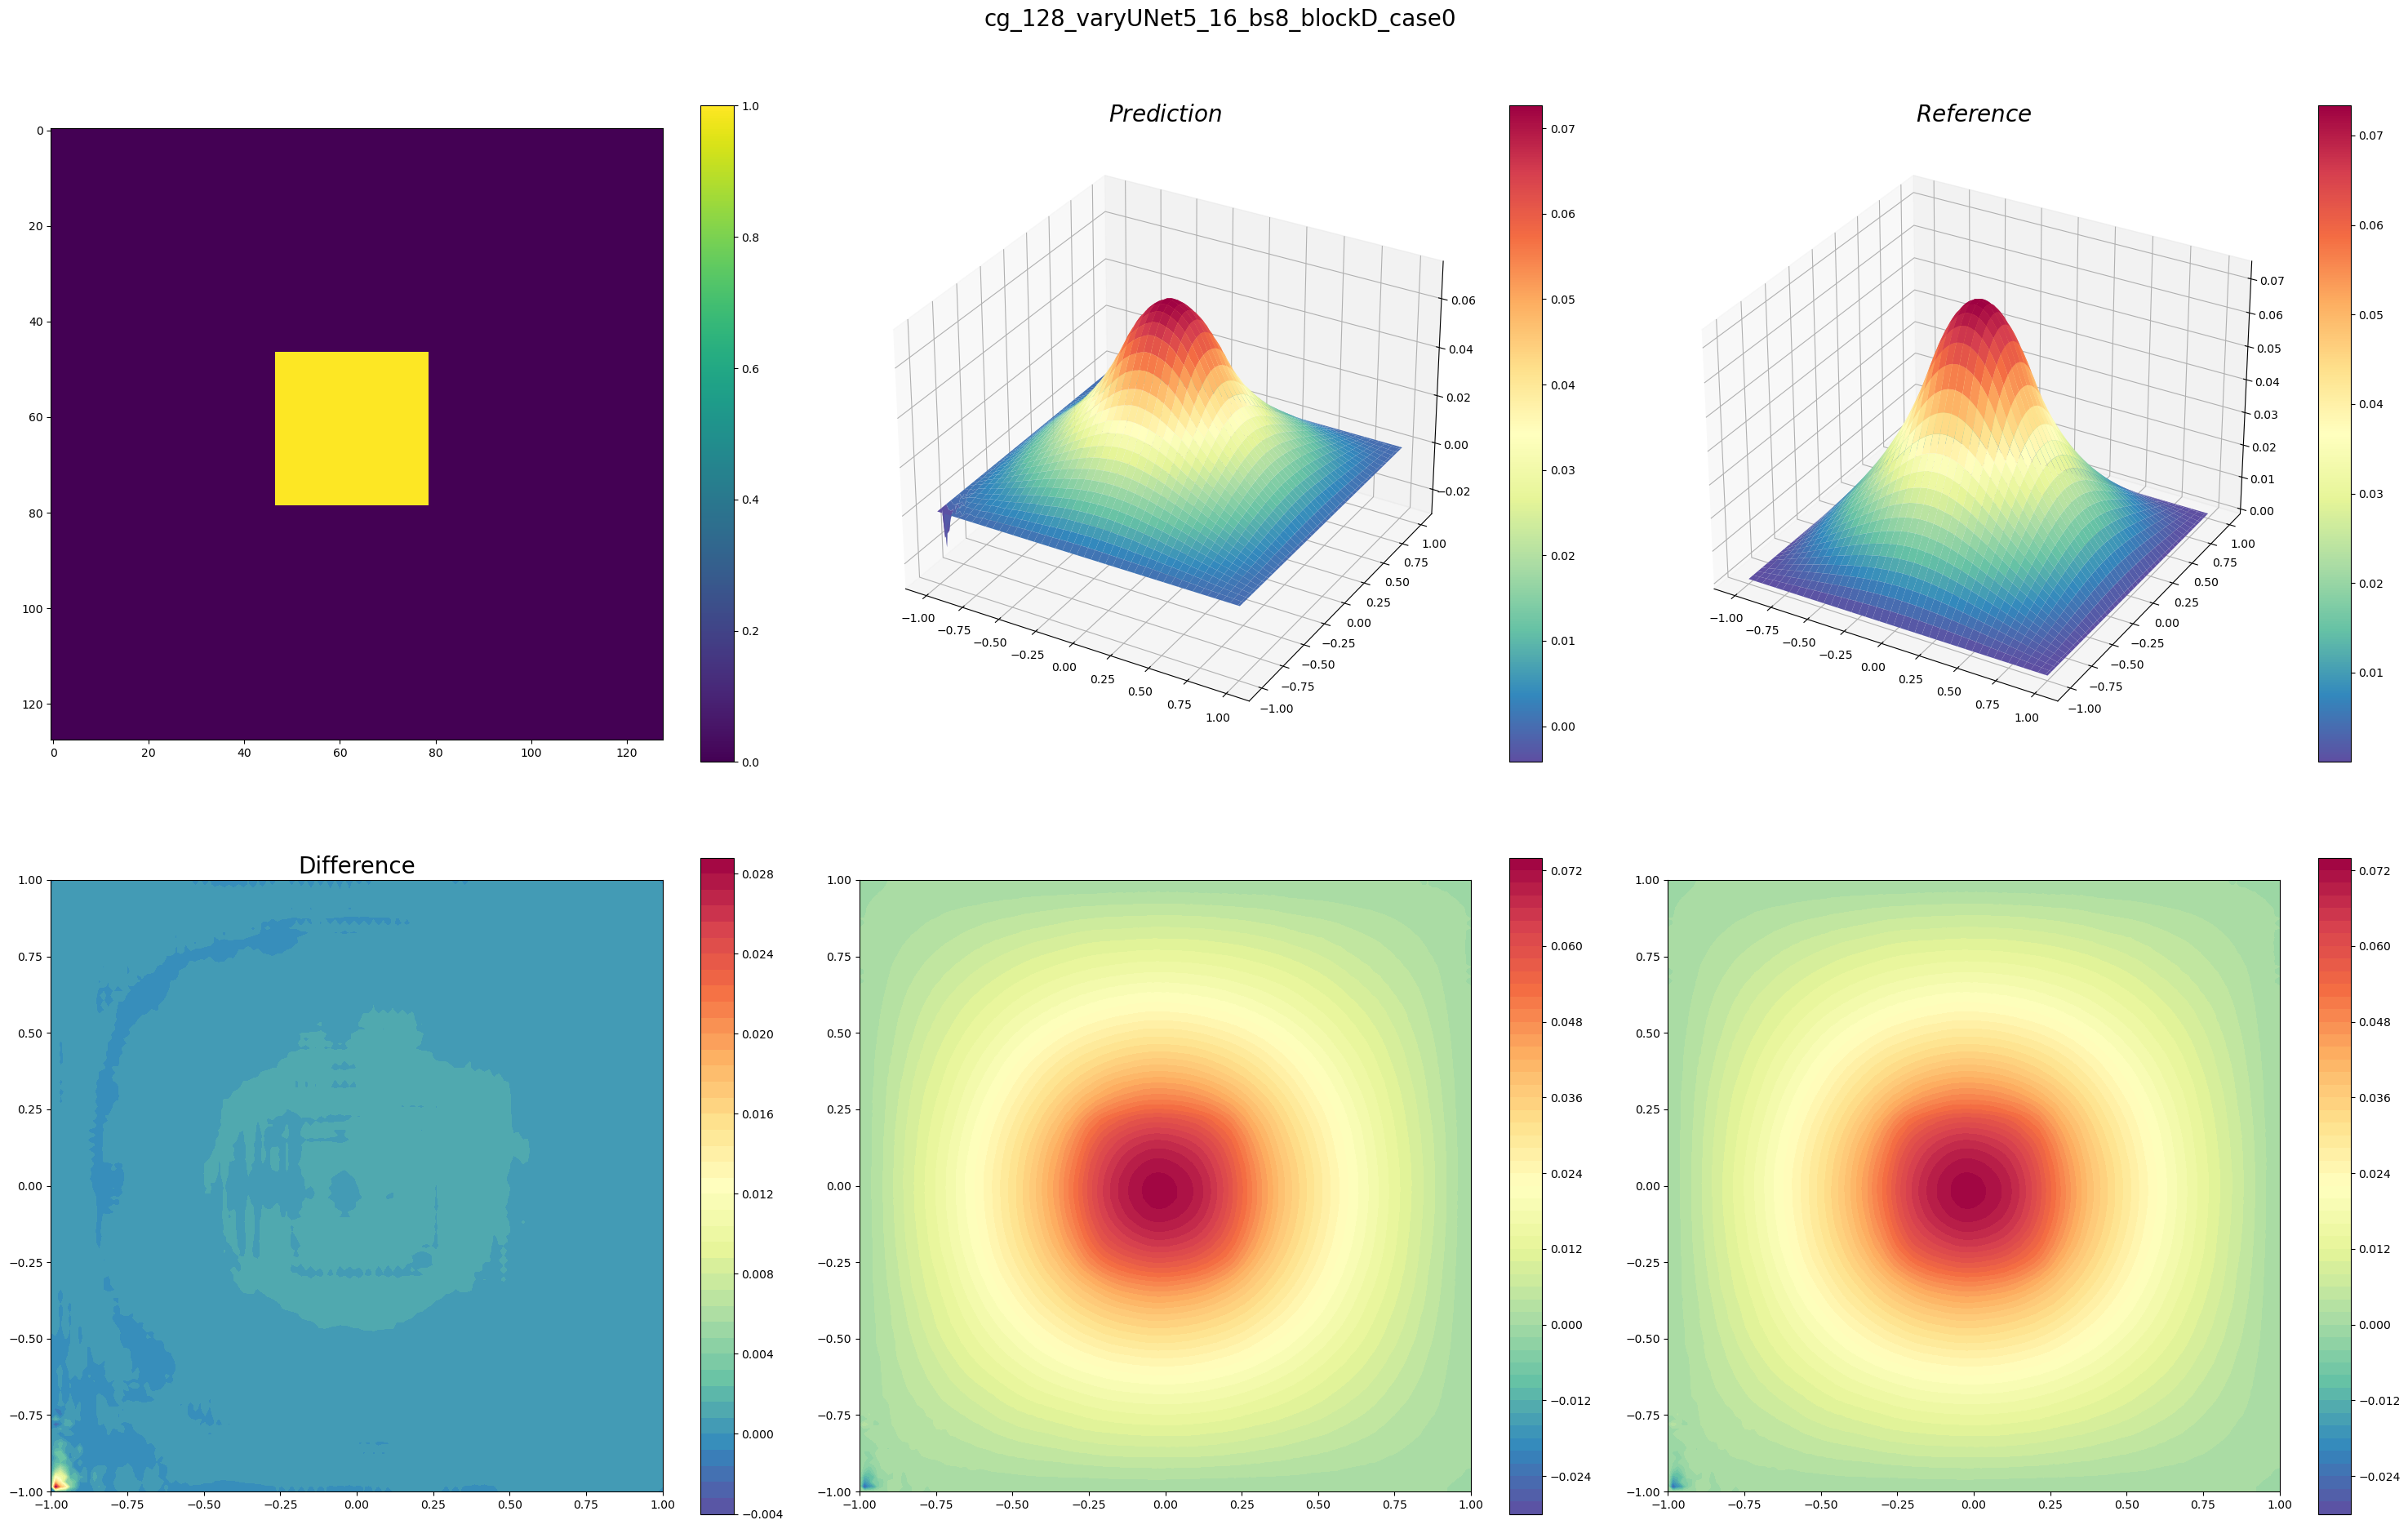

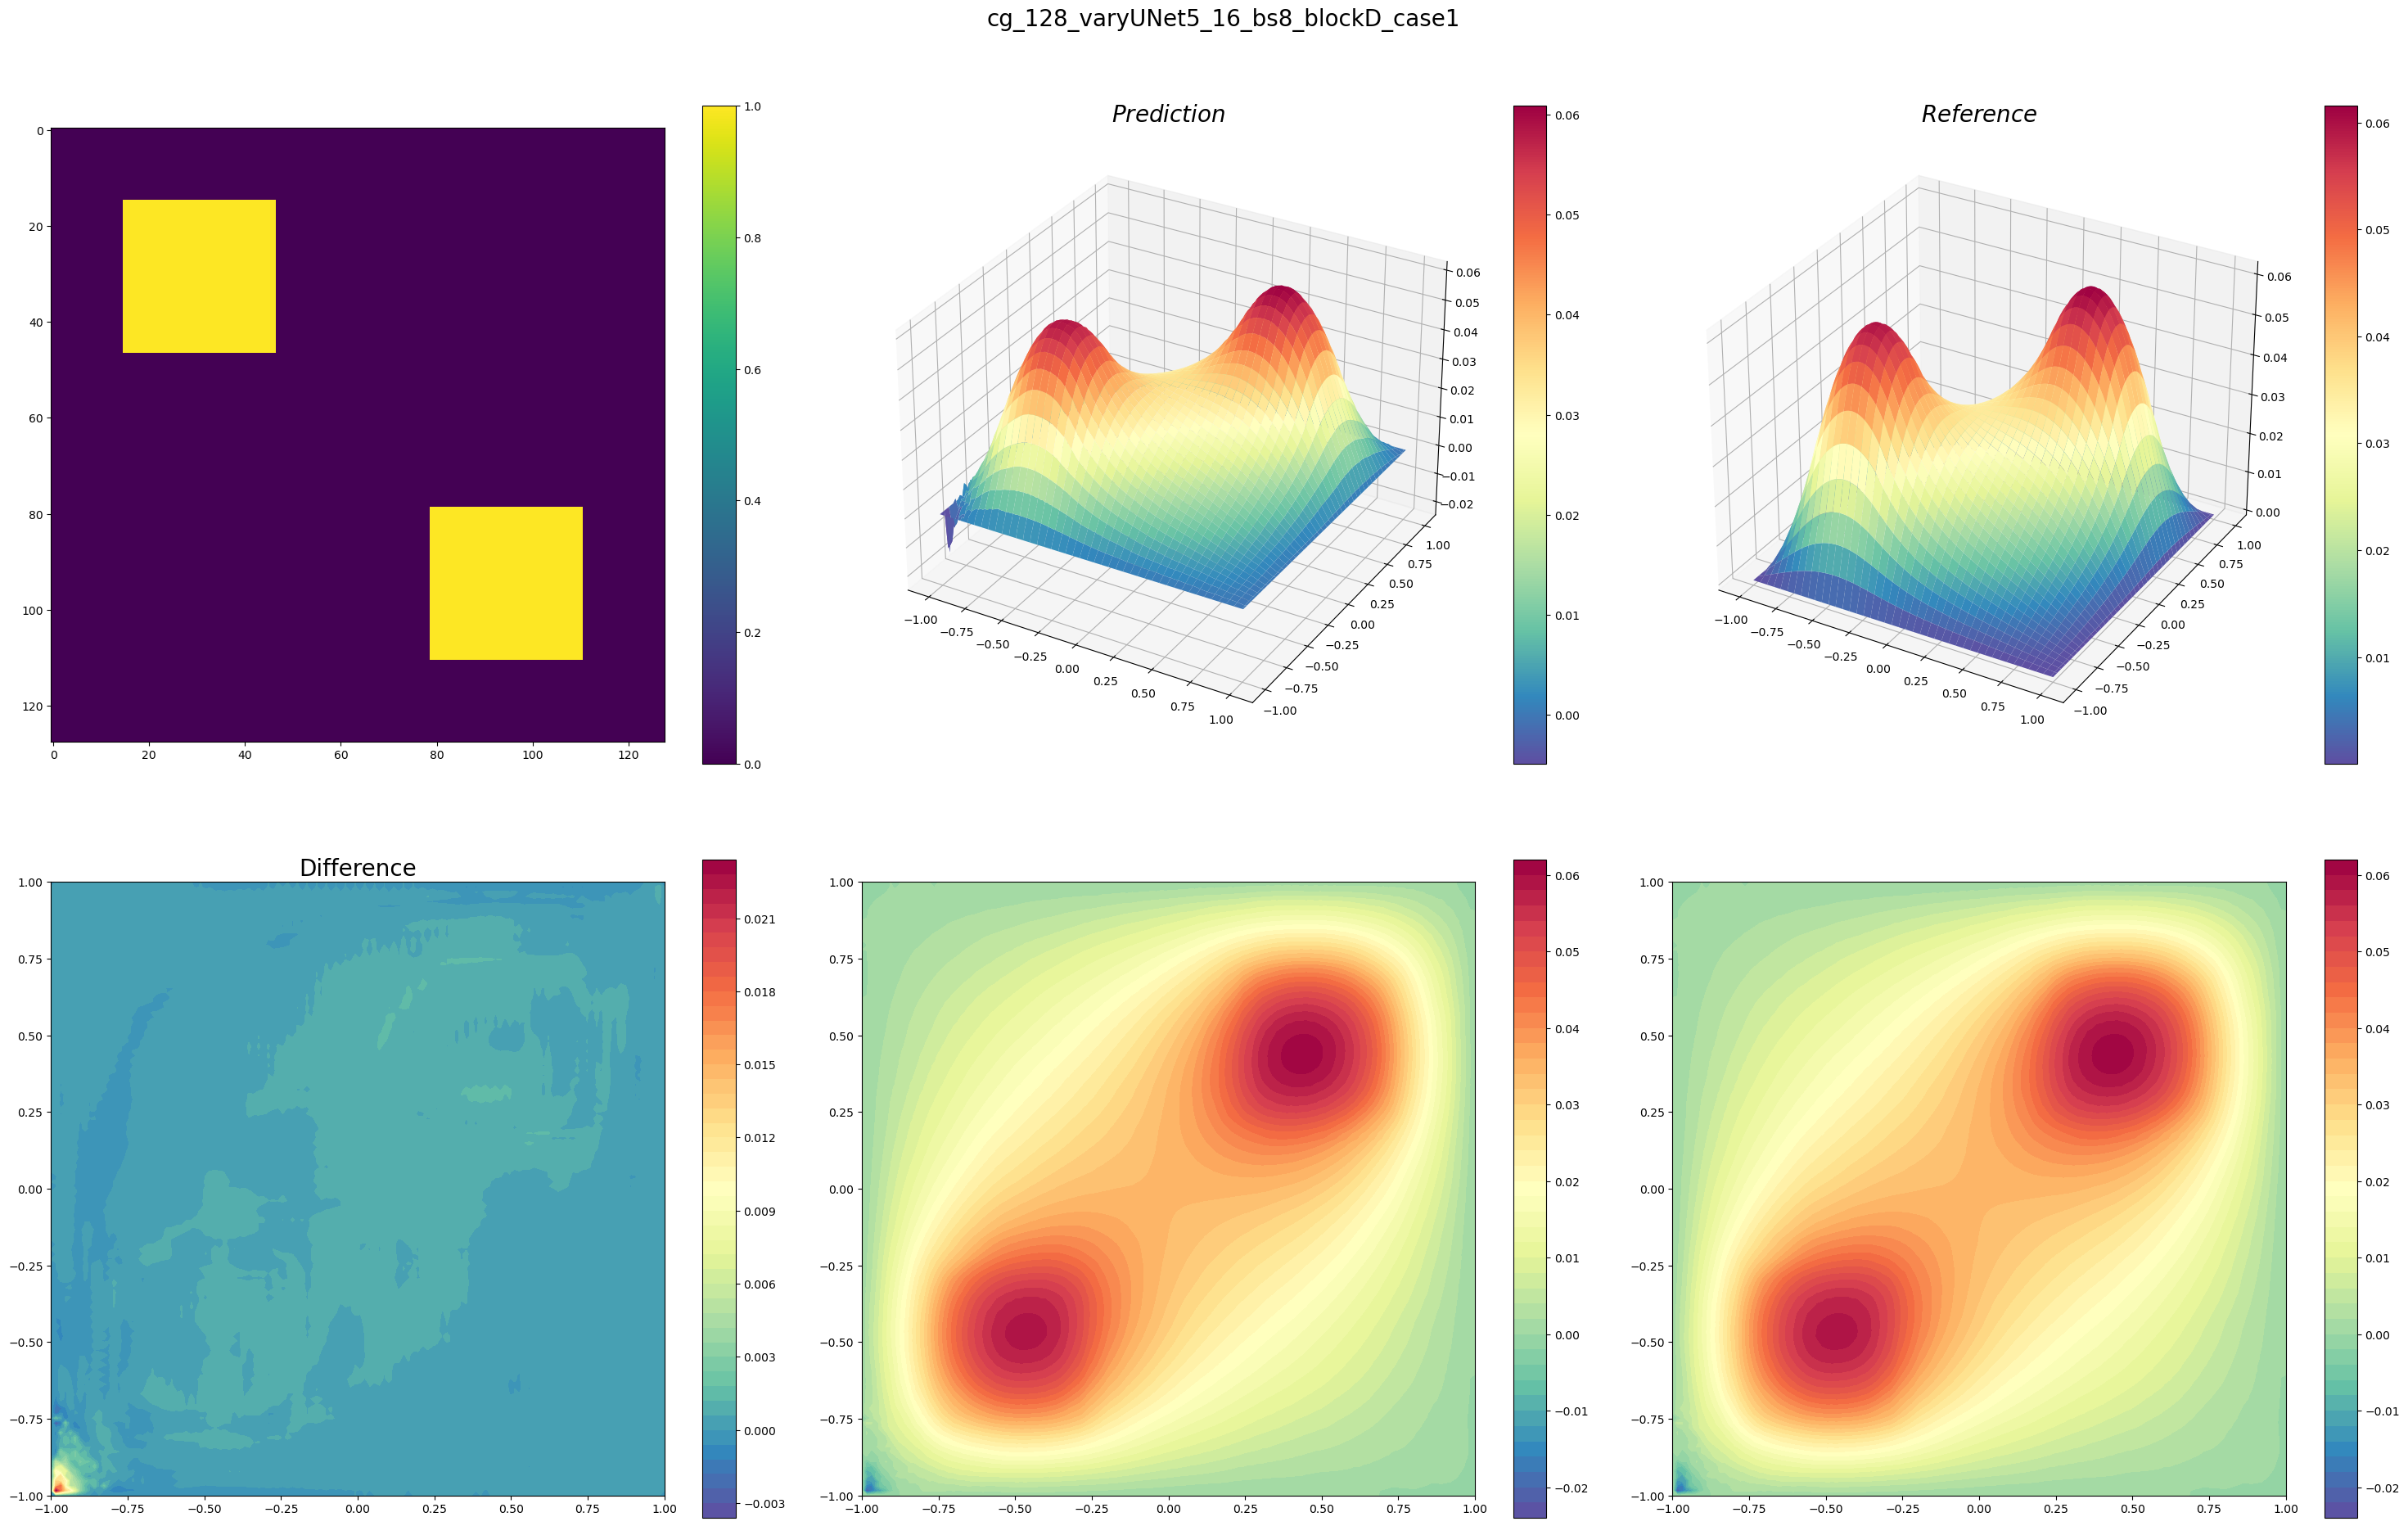

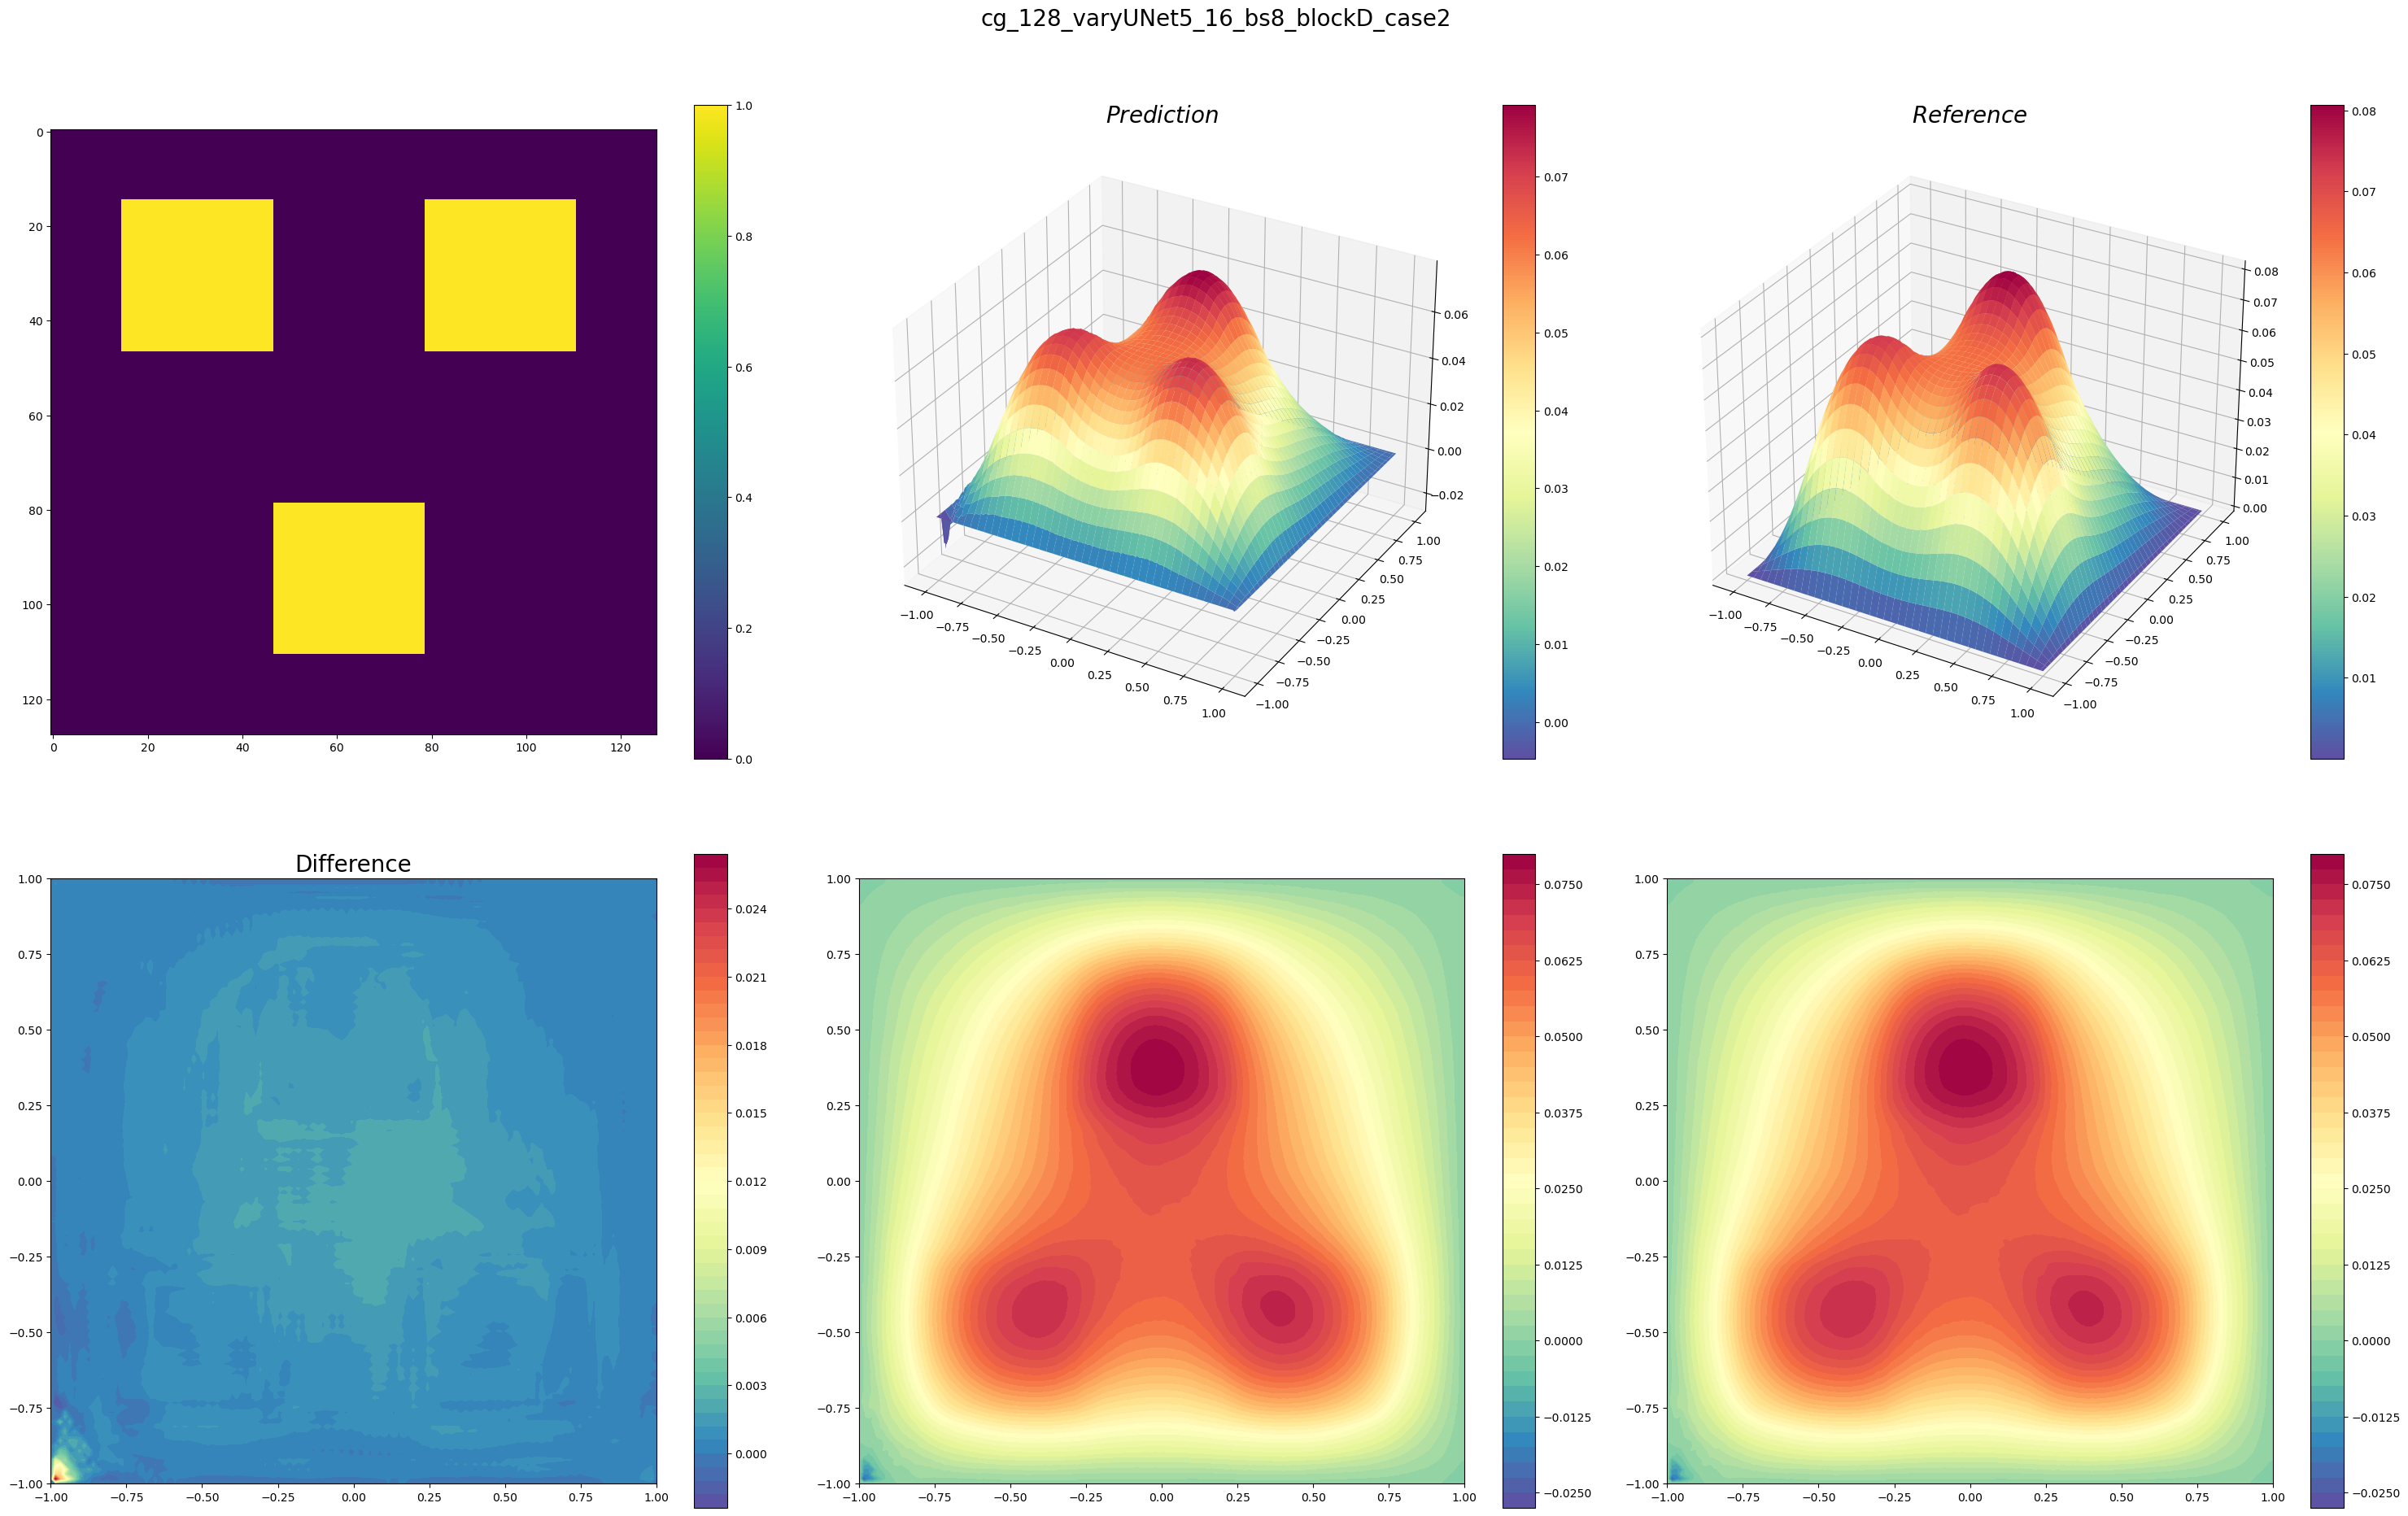

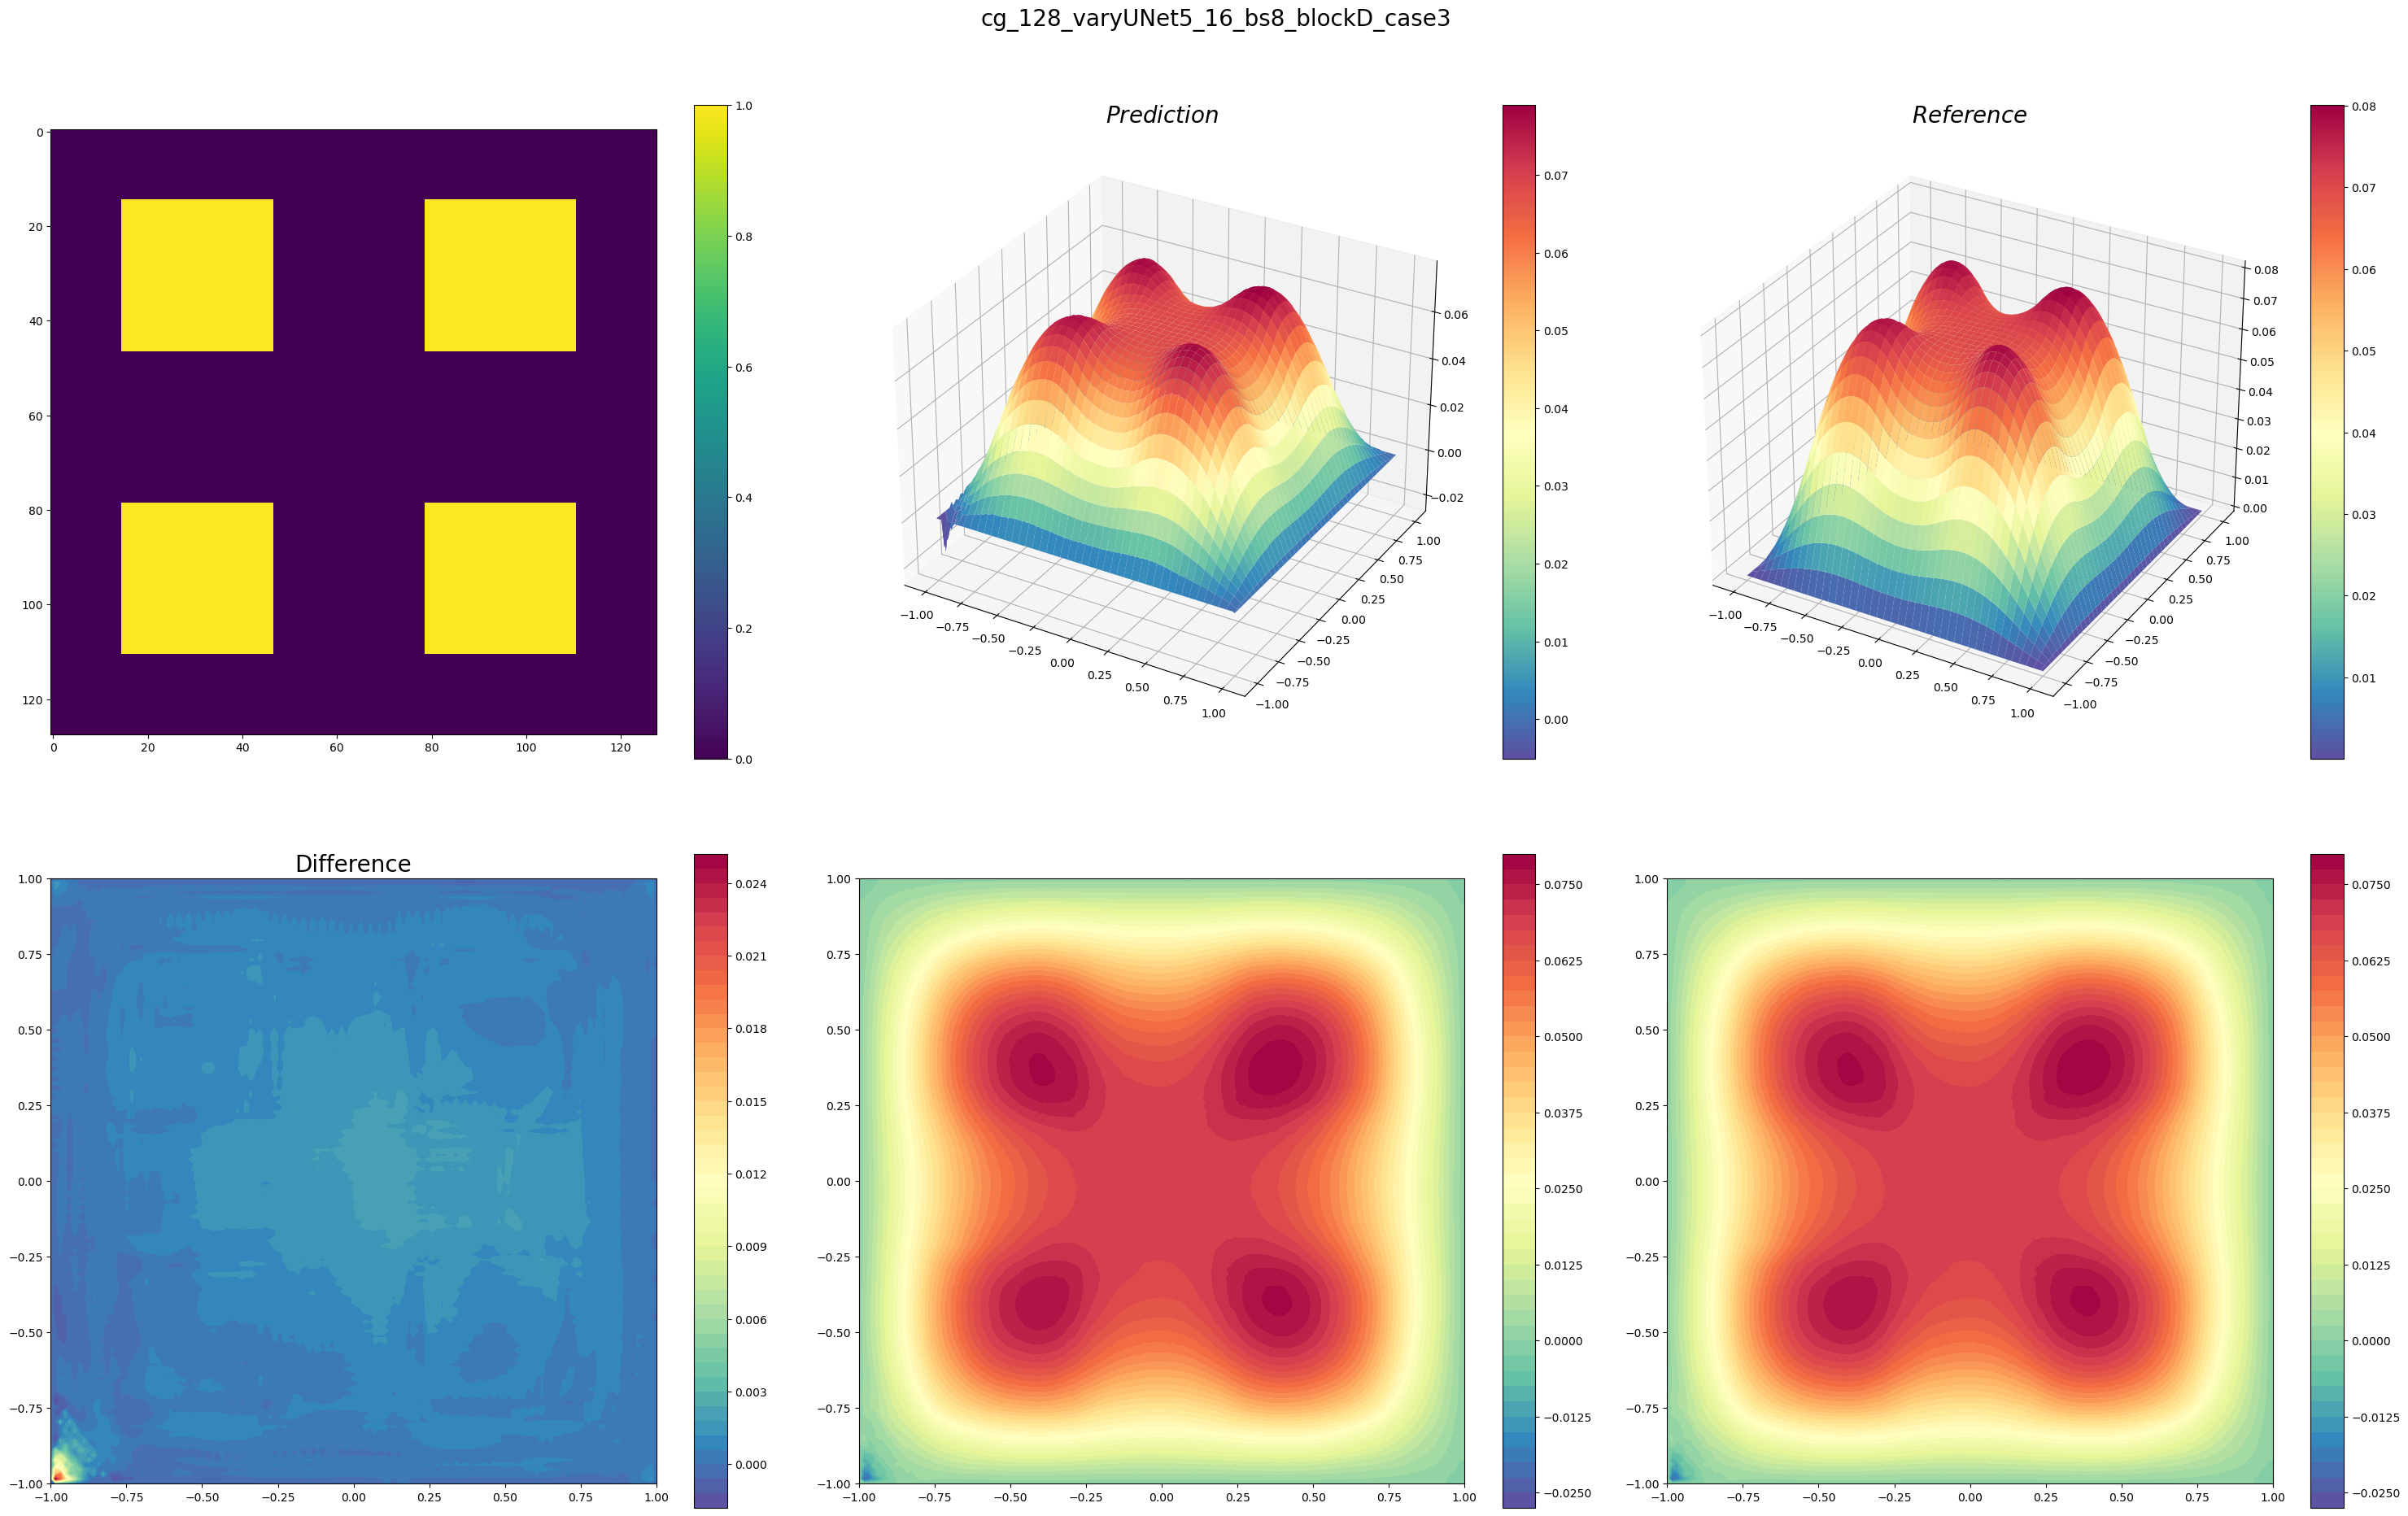

In [42]:
def test_block_cases(cases, ckpt_path, imgs_save_path, a=1):
    for folder in ckpt_path.glob('*block*'):
        # Get all parameters from the ckpt name
        backward_method, n, model_name, features, bs, data_type = folder.name.split('_')
        n = int(n)
        layers = int(model_name[-1])
        model_name = model_name[:-1]
        features = int(features)
        bs = int(bs[2:])
        boundary_type = data_type[-1]
        data_type = data_type[:-1]

        h = 2*a / (n -1)
        h2 = h ** 2
        x = np.linspace(-a, a, n)
        y = np.linspace(-a, a, n)
        xx, yy = np.meshgrid(x, y)
        
        # get network
        mat_path = f'./data/{n}/mat/'
        net = model_names[model_name](layers = layers, features = features, boundary_type = boundary_type)
        pl_module = LAModel(net, a, n, data_path = mat_path, backward_type=backward_method, boundary_type=boundary_type)

        # get matrix
        # A = pl_module.A
        lu, piv = sla.lu_factor(pl_module.A.to_dense().numpy())
        
        #get image save path and ckpy file path
        img_path = imgs_save_path/folder.name
        ckpt = folder/'version_0'/'checkpoints'/'last.ckpt'

        # Load ckpt
        ckpt = torch.load(ckpt)
        pl_module.load_state_dict(ckpt['state_dict'])
        pl_module.freeze()

        # Test all cases
        for i, case in enumerate(cases):
            case_img_save_path = img_path/f'case{i}'
            if not case_img_save_path.is_dir():
                case_img_save_path.mkdir(parents=True, exist_ok = True)
            f = np.zeros((n, n))
            for rect in case:
                x_start = int((rect[0] + a) / h)
                x_end = int((rect[0] + rect[2] + a) / h)
                y_start = int((rect[1] + a) / h)
                y_end = int((rect[1] + rect[3] + a) / h)
                f[y_start:y_end, x_start:x_end] = 1
                    
            # Get input tensor for networks
            input_tensor = np.stack([xx, yy, f], axis=0)
            input_tensor = torch.from_numpy(input_tensor).float()
        
            # Get b for linear equations, If the value of boundary changed should fix here
            b = f.reshape(n**2) * h2
            if boundary_type == 'D':
                b = apply_diri_bc(b, {'top':0, 'bottom':0, 'left':0, 'right':0})
            elif boundary_type == 'N':
                b = apply_diri_bc(b)
                b = apply_neumann_bc(b, h, f)

            # get predicted value and real ans
            ans = sla.lu_solve((lu, piv), b).reshape(n, n)
            pre = pl_module(input_tensor[None, ...])
            pre = pl_module.padder(pre).numpy().reshape(n, n)

            # Draw
            draw_block(f'{folder.name}_case{i}',f, pre, ans, xx, yy)

            # Save images
            # save_img(case_img_save_path, f, pre, ans, xx, yy, True)
        return

block_cases = [
    [(-0.25, -0.25, 0.5, 0.5)],
    [(-0.75, -0.75, 0.5, 0.5), (0.25, 0.25, 0.5, 0.5)],
    [(-0.75, -0.75, 0.5, 0.5), (0.25, -0.75, 0.5, 0.5), (-0.25, 0.25, 0.5, 0.5)],
    [(-0.75, -0.75, 0.5, 0.5), (0.25, -0.75, 0.5, 0.5), (-0.75, 0.25, 0.5, 0.5), (0.25, 0.25, 0.5, 0.5)],
]
ckpt_path = Path('./lightning_logs/')
imgs_save_path = Path('./images/')
test_block_cases(block_cases, ckpt_path, imgs_save_path)